In [1]:
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from Utils.recsys2022DataReader import *

In [2]:
URM_train = load_1K_FinalURMTrain()
URM_validation = load_1K_FinalURMValid()

In [3]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.Hybrid.LinearHybridRecommender import LinearHybridTwoRecommenderTwoVariables

IALS_init = ImplicitALSRecommender(URM_train)
IALS_init.fit(factors=110, alpha=7, iterations=57, regularization=0.0008866558623568822)

RP3beta_init = RP3betaRecommender(URM_train)
RP3beta_init.fit(topK=77, alpha=0.8401946814961014, beta=0.3073181471251768)

SLIM_init = SLIMElasticNetRecommender(URM_train)
SLIM_init.fit(topK=250, alpha=0.00312082198837027, l1_ratio=0.009899185175306373)

ItemKNN_init = ItemKNNCFRecommender(URM_train)
ItemKNN_init.fit(topK=123, shrink=510, similarity="cosine", feature_weighting="TF-IDF")

hybrid1_init = LinearHybridTwoRecommenderTwoVariables(URM_train, Recommender_1=RP3beta_init,
                                                          Recommender_2=SLIM_init)
hybrid1_init.fit(alpha=0.40726736669265445, beta=0.7317482903276693)

hybrid2_init = LinearHybridTwoRecommenderTwoVariables(URM_train, Recommender_1=IALS_init,
                                                          Recommender_2=hybrid1_init)
hybrid2_init.fit(alpha=0.019318928403041356, beta=0.8537494424674974)

candidate_generator_recommender = LinearHybridTwoRecommenderTwoVariables(URM_train, Recommender_1=hybrid2_init,
                                                                Recommender_2=ItemKNN_init)
candidate_generator_recommender.fit(alpha=0.5182132379810547, beta=4.19321787406275e-06)

  0%|          | 0/57 [00:00<?, ?it/s]

RP3betaRecommender: Similarity column 24507 (100.0%), 3857.55 column/sec. Elapsed time 6.35 sec
SLIMElasticNetRecommender: Processed 1399 ( 5.7%) in 1.00 min. Items per second: 23.30
SLIMElasticNetRecommender: Processed 2911 (11.9%) in 2.00 min. Items per second: 24.25
SLIMElasticNetRecommender: Processed 4495 (18.3%) in 3.00 min. Items per second: 24.96
SLIMElasticNetRecommender: Processed 6119 (25.0%) in 4.00 min. Items per second: 25.49
SLIMElasticNetRecommender: Processed 7748 (31.6%) in 5.00 min. Items per second: 25.82
SLIMElasticNetRecommender: Processed 9390 (38.3%) in 6.00 min. Items per second: 26.07
SLIMElasticNetRecommender: Processed 11020 (45.0%) in 7.00 min. Items per second: 26.23
SLIMElasticNetRecommender: Processed 12693 (51.8%) in 8.00 min. Items per second: 26.43
SLIMElasticNetRecommender: Processed 14313 (58.4%) in 9.00 min. Items per second: 26.50
SLIMElasticNetRecommender: Processed 16025 (65.4%) in 10.00 min. Items per second: 26.70
SLIMElasticNetRecommender: Pr

## Building dataframe

In [4]:
URM_all = createURMBinary()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:57: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [5]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_all.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [6]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
41624,NaN
41625,NaN
41626,NaN


In [7]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 41629/41629 [01:37<00:00, 427.89it/s]


In [8]:
training_dataframe

,ItemID
UserID,
0,"[617, 752, 20, 5735, 18484, 29, 391, 23, 673, ..."
1,"[6874, 1068, 665, 393, 62, 60, 598, 1689, 56, ..."
2,"[121, 126, 8875, 1080, 453, 10221, 15454, 1308..."
3,"[20, 21, 352, 58, 269, 557, 536, 121, 109, 393..."
4,"[23, 80, 21, 68, 124, 64, 56, 436, 2119, 2106,..."
...,...
41624,"[22403, 617, 10221, 752, 18939, 7864, 14400, 1..."
41625,"[23, 53, 393, 909, 56, 596, 495, 494, 347, 498..."
41626,"[21, 61, 12118, 23, 270, 268, 387, 1693, 343, ..."


In [9]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,617
0,752
0,20
0,5735
0,18484
...,...
41628,1546
41628,273
41628,18782


## Add validation test

In [10]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,1715
1,0,2257
2,0,2730
3,0,5735
4,0,8540
...,...,...
233191,41627,18212
233192,41628,29
233193,41628,2402
233194,41628,10082


In [11]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,617,left_only
1,0,752,left_only
2,0,20,left_only
3,0,5735,both
4,0,18484,left_only
...,...,...,...
1248865,41628,1546,left_only
1248866,41628,273,left_only
1248867,41628,18782,left_only
1248868,41628,898,left_only


In [12]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,617,False
1,0,752,False
2,0,20,False
3,0,5735,True
4,0,18484,False
...,...,...,...
1248865,41628,1546,False
1248866,41628,273,False
1248867,41628,18782,False
1248868,41628,898,False



## Now we add some features like different recommenders predictions

In [13]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

ItemKNN = ItemKNNCFRecommender(URM_all)
ItemKNN.fit(topK=123, shrink=510, similarity="cosine", feature_weighting="TF-IDF")

P3alpha = P3alphaRecommender(URM_all)
P3alpha.fit(topK=116, alpha=0.8763131065621229)

SLIM = SLIMElasticNetRecommender(URM_all)
SLIM.fit(topK=396, alpha=0.0026732398099801086, l1_ratio=0.00859835955640564)

RP3 = RP3betaRecommender(URM_all)
RP3.fit(topK=54, alpha=0.8285172350759491, beta=0.292180138700761)


other_algorithms = {
    "ItemKNN": ItemKNN,
    "P3alpha": P3alpha,
    "SLIM": SLIM,
    "RP3": RP3
}

Similarity column 24507 (100.0%), 5973.02 column/sec. Elapsed time 4.10 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 3533.73 column/sec. Elapsed time 6.94 sec
SLIMElasticNetRecommender: Processed 1321 ( 5.4%) in 1.00 min. Items per second: 21.99
SLIMElasticNetRecommender: Processed 2723 (11.1%) in 2.00 min. Items per second: 22.68
SLIMElasticNetRecommender: Processed 4188 (17.1%) in 3.00 min. Items per second: 23.25
SLIMElasticNetRecommender: Processed 5679 (23.2%) in 4.00 min. Items per second: 23.65
SLIMElasticNetRecommender: Processed 7174 (29.3%) in 5.00 min. Items per second: 23.90
SLIMElasticNetRecommender: Processed 8673 (35.4%) in 6.00 min. Items per second: 24.08
SLIMElasticNetRecommender: Processed 10168 (41.5%) in 7.00 min. Items per second: 24.20
SLIMElasticNetRecommender: Processed 11669 (47.6%) in 8.00 min. Items per second: 24.30
SLIMElasticNetRecommender: Processed 13175 (53.8%) in 9.00 min. Items per second: 24.39
SLIMElasticNetRecommender: Processed 14672

In [14]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 41629/41629 [01:03<00:00, 655.80it/s]


,UserID,ItemID,Label,ItemKNN,P3alpha,SLIM,RP3
0,0,617,False,4.201604,0.033769,0.268843,0.088610
1,0,752,False,4.778629,0.032449,0.268370,0.086998
2,0,20,False,7.917598,0.131257,0.190101,0.151179
3,0,5735,True,5.543283,0.062471,0.237567,0.162682
4,0,18484,False,2.548573,0.029527,0.237195,0.080570
...,...,...,...,...,...,...,...
1248865,41628,1546,False,0.822460,0.000000,0.015798,0.000000
1248866,41628,273,False,0.707531,0.000000,0.028615,0.000000
1248867,41628,18782,False,0.332381,0.007713,0.016877,0.027080
1248868,41628,898,False,1.106893,0.000000,0.008625,0.011687


## We add the item popularity and profile length

In [15]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,SLIM,RP3,item_popularity
0,0,617,False,4.201604,0.033769,0.268843,0.088610,603
1,0,752,False,4.778629,0.032449,0.268370,0.086998,556
2,0,20,False,7.917598,0.131257,0.190101,0.151179,4243
3,0,5735,True,5.543283,0.062471,0.237567,0.162682,388
4,0,18484,False,2.548573,0.029527,0.237195,0.080570,1156
...,...,...,...,...,...,...,...,...
1248865,41628,1546,False,0.822460,0.000000,0.015798,0.000000,250
1248866,41628,273,False,0.707531,0.000000,0.028615,0.000000,641
1248867,41628,18782,False,0.332381,0.007713,0.016877,0.027080,216
1248868,41628,898,False,1.106893,0.000000,0.008625,0.011687,349


In [16]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,SLIM,RP3,item_popularity,user_profile_len
0,0,617,False,4.201604,0.033769,0.268843,0.088610,603,55
1,0,752,False,4.778629,0.032449,0.268370,0.086998,556,55
2,0,20,False,7.917598,0.131257,0.190101,0.151179,4243,55
3,0,5735,True,5.543283,0.062471,0.237567,0.162682,388,55
4,0,18484,False,2.548573,0.029527,0.237195,0.080570,1156,55
...,...,...,...,...,...,...,...,...,...
1248865,41628,1546,False,0.822460,0.000000,0.015798,0.000000,250,19
1248866,41628,273,False,0.707531,0.000000,0.028615,0.000000,641,19
1248867,41628,18782,False,0.332381,0.007713,0.016877,0.027080,216,19
1248868,41628,898,False,1.106893,0.000000,0.008625,0.011687,349,19


In [17]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,SLIM,RP3,item_popularity,user_profile_len
0,0,617,False,4.201604,0.033769,0.268843,0.088610,603,55
1,0,149,False,4.939782,0.041671,0.066627,0.072990,614,55
2,0,2494,False,5.213657,0.070379,0.130381,0.111937,772,55
3,0,1534,False,4.801333,0.048760,0.095758,0.048841,502,55
4,0,1023,False,4.681795,0.010211,0.084978,0.020989,1168,55
...,...,...,...,...,...,...,...,...,...
1248865,41628,2904,False,2.791947,0.018678,0.108751,0.075906,102,19
1248866,41628,769,False,4.435085,0.038295,0.260231,0.138324,142,19
1248867,41628,898,False,1.106893,0.000000,0.008625,0.011687,349,19
1248868,41628,14709,False,0.817198,0.008593,0.037472,0.049140,41,19


## Train XGBoost

In [18]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [19]:
from xgboost import XGBRanker

In [20]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [21]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=True, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

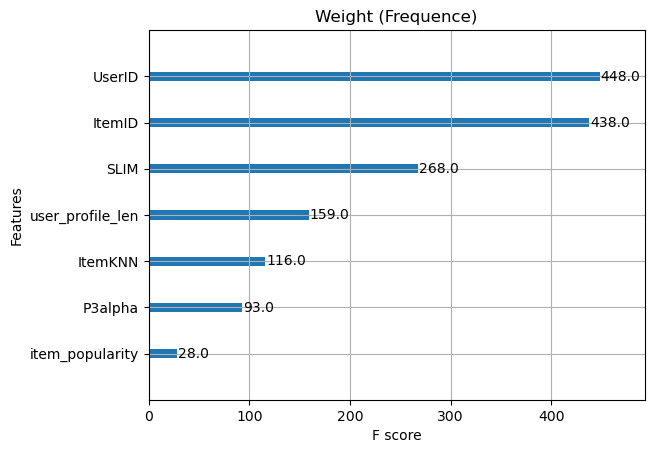

In [22]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [23]:
targetUsers = pd.read_csv('Input/data_target_users_test.csv')['user_id']

targetUsers = targetUsers.tolist()

In [25]:
import operator
import csv
with open('XGBoostPredictions/first.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['user_id', 'item_list'])

    for i in tqdm(range(n_users)):
        if i in targetUsers:
            X_to_predict = X_train[X_train["UserID"] == i]
            predictions = XGB_model.predict(X_to_predict)
            items = training_dataframe.loc[training_dataframe["UserID"]==i]
            predictedItems = items["ItemID"]

            predictionsToSubmit = {}
            j = 0
            for item in predictedItems:
                predictionsToSubmit[item] = predictions[j]
                j+=1

            sorted_predictions = dict(sorted(predictionsToSubmit.items(), key=operator.itemgetter(1),reverse=True))
            best10 = list(sorted_predictions.keys())[:10]
            writer.writerow([i, str(np.array(best10))[1:-1]])

100%|██████████| 41629/41629 [03:04<00:00, 225.42it/s]
